# Thermocapillary flows: 2D Droplet motion

In [1]:
from pystencils.session import *
from lbmpy.session import *

from pystencils.astnodes import LoopOverCoordinate
from pystencils.boundaries import BoundaryHandling

from lbmpy.phasefield_allen_cahn.contact_angle import ContactAngle
from lbmpy.phasefield_allen_cahn.kernel_equations import *
from lbmpy.phasefield_allen_cahn.parameter_calculation import calculate_parameters_droplet_migration, AllenCahnParameters
from lbmpy.advanced_streaming import LBMPeriodicityHandling
from lbmpy.boundaries import NoSlip, LatticeBoltzmannBoundaryHandling

If `cupy` is installed the simulation automatically runs on GPU

In [2]:
try:
    import cupy
except ImportError:
    cupy = None
    gpu = False
    target = ps.Target.CPU
    print('No cupy installed')

if cupy:
    gpu = True
    target = ps.Target.GPU

## Overview

In this tutorial, we will provide an introduction to thermocapillary flows and solve an example setup using `lbmpy` and `pystencils`. This tutorial builds upon the conservative Allen-Cahn tutorial. Thus it is highly recommended to read mentioned tutorial first.

Thermocapillary flows refer to the motion of fluids induced by temperature gradients at liquid interfaces. They play a crucial role in various natural and industrial processes, such as microfluidics, materials processing, and the behavior of liquid droplets in microgravity environments.

The experimental setup shown in this tutorial encompasses the application of thermocapillary `LBM` to investigate the dynamic behavior of a droplet within a microchannel. To replicate the thermal effects induced by a laser, a heat source is introduced within the channel as,

$$
\begin{align}
	\label{eq:HeatSource}
	q_T =
	\begin{cases}
		Q_s \exp{\left(-2 \frac{\left(x - x_s\right)^2 + \left(y - y_s\right)^2 + \left(z - z_s\right)^2}{w_s^2}\right)}, & \text{if } \left[\left(x - x_s\right)^2 + \left(y - y_s\right)^2 + \left(z - z_s\right)^2\right] \geq d_s^2 \\
		0, & \text{otherwise}
	\end{cases};
\end{align}
$$

\noindent Here, $Q_s$ signifies the maximum heat flux generated by the laser, while $x_s$, $y_s$, and $z_s$ denote the precise laser position.  For the two-dimensional cases, the $z$-component is disregarded. The extent of heat dispersion is defined by $d_s$, while $w_s$ serves as a key parameter governing the heat flux profile.

## Geometry Setup

First of all the stencils for the phase-field LB step as well as the stencil for the hydrodynamic LB step are defined. According to the stencils the simulation runs either in 2D or 3D

In [3]:
stencil_phase = LBStencil(Stencil.D2Q9)
stencil_hydro = LBStencil(Stencil.D2Q9)
stencil_thermal = LBStencil(Stencil.D2Q9)
assert(stencil_phase.D == stencil_hydro.D == stencil_thermal.D)

Definition of the parameters used in this tutorial

In [4]:
# pysical simulation time (timesteps will be calculated with reference time)
simulation_time = 20
# domain 
Radius = 32
domain_size = (8 * Radius, 2 * Radius)
midpoint = (65, 0)

T_c = 0

# time step
timesteps_temperature = int(10000)

Ca = 0.01
Re = 0.16
Ma = 0.08
Pe = 1.0

sigma_ref = 5e-3
heat_ratio = 1

parameters = calculate_parameters_droplet_migration(radius=Radius, reynolds_number=Re,
                                                    capillary_number=Ca, marangoni_number=Ma,
                                                    peclet_number=Pe, viscosity_ratio=1,
                                                    heat_ratio=heat_ratio, interface_width=4,
                                                    reference_surface_tension=sigma_ref)
parameters.interface_thickness = 4
u_max = parameters.velocity_wall
timesteps = simulation_time * parameters.reference_time

contact_angle_degree = 90

In [5]:
parameters

Name,SymPy Symbol,Value
Density heavy phase,$\rho_{H}$,$1.0$
Density light phase,$\rho_{L}$,$1.0$
Relaxation time heavy phase,$\tau_{H}$,$0.3$
Relaxation time light phase,$\tau_{L}$,$0.3$
Relaxation rate Allen Cahn LB,$\omega_{\phi}$,$1.97628458498024$
Gravitational acceleration,$F_{g}$,$0.0$
Interface thickness,$W$,$4$
Mobility,$M_{m}$,$0.002$
Surface tension,$\sigma$,$0.0$
Heat Conductivity Heavy,$\kappa_{H}$,$0.2$


## Fields

As a next step all fields which are needed get defined. To do so we create a `datahandling` object. More details about it can be found in the third tutorial of the [pystencils framework]( http://pycodegen.pages.walberla.net/pystencils/). Basically it holds all fields and manages the kernel runs.

In [6]:
# create a datahandling object
dh = ps.create_data_handling((domain_size), periodicity=(True, False), default_target=target)

# fields 
g = dh.add_array("g", values_per_cell=len(stencil_hydro))
dh.fill("g", 0.0, ghost_layers=True)
h = dh.add_array("h",values_per_cell=len(stencil_phase))
dh.fill("h", 0.0, ghost_layers=True)
f = dh.add_array("f",values_per_cell=len(stencil_thermal))
dh.fill("f", 0.0, ghost_layers=True)

g_tmp = dh.add_array("g_tmp", values_per_cell=len(stencil_hydro))
dh.fill("g_tmp", 0.0, ghost_layers=True)
h_tmp = dh.add_array("h_tmp",values_per_cell=len(stencil_phase))
dh.fill("h_tmp", 0.0, ghost_layers=True)
f_tmp = dh.add_array("f_tmp",values_per_cell=len(stencil_thermal))
dh.fill("f_tmp", 0.0, ghost_layers=True)

u = dh.add_array("u", values_per_cell=dh.dim)
dh.fill("u", 0.0, ghost_layers=True)

C = dh.add_array("C")
dh.fill("C", 0.0, ghost_layers=True)
C_tmp = dh.add_array("C_tmp")
dh.fill("C_tmp", 0.0, ghost_layers=True)

temperature = dh.add_array("temperature")
dh.fill("temperature", parameters.tmp_ref, ghost_layers=True)

## Parameter definition

The next step is to calculate all parameters which are needed for the simulation. 

In [7]:
one = sp.Number(1)
two = sp.Number(2)
k_l = parameters.symbolic_heat_conductivity_light
k_h = parameters.symbolic_heat_conductivity_heavy

# relaxation rate for the phase-field LBM step
w_c = 1.0/(0.5 + (3.0 * parameters.symbolic_mobility))
# relaxation rate for the hydrodynamic LBM step
omega = parameters.omega(C)
# relaxation rate for the thermal LBM solver
conductivity = ((one - C.center) / two) * k_l + ((one + C.center) / two) * k_h
w_t = one/(sp.Rational(1, 2) + (sp.Number(3) * conductivity))

In [8]:
# density for the whole domain
rho_L = parameters.symbolic_density_light
rho_H = parameters.symbolic_density_heavy
density = rho_L + C.center * (rho_H - rho_L)

## Definition of the lattice Boltzmann methods

In [9]:
config_phase = LBMConfig(stencil=stencil_phase, method=Method.CENTRAL_MOMENT,
                         compressible=True, zero_centered=False,
                         relaxation_rates=[w_c, ] * stencil_phase.Q,
                         force=sp.symbols(f"F_:{stencil_phase.D}"),
                         output={'density': C_tmp}, 
                         velocity_input=u)

method_phase = create_lb_method(config_phase)
method_phase

In [10]:
config_hydro = LBMConfig(stencil=stencil_hydro, method=Method.CENTRAL_MOMENT,
                         compressible=False,
                         force=sp.symbols(f"F_:{stencil_hydro.D}"),
                         output={'velocity': u},
                         relaxation_rates=[omega, omega, 1, 1])


method_hydro = create_lb_method(config_hydro)
method_hydro

In [11]:
config_thermal = LBMConfig(stencil=stencil_thermal, method=Method.CENTRAL_MOMENT,
                           compressible=True, zero_centered=False, relaxation_rate=w_t,
                           output={'density': temperature}, velocity_input=u)

method_thermal = create_lb_method(lbm_config=config_thermal)
method_thermal

## Initialization

In [12]:
h_updates = initializer_kernel_phase_field_lb(method_phase, C, u, h, parameters)
g_updates = initializer_kernel_hydro_lb(method_hydro, 1.0, u, g)
f_updates = pdf_initialization_assignments(method_thermal, temperature, u, f)

h_init = ps.create_kernel(h_updates, target=dh.default_target, cpu_openmp=True).compile()
g_init = ps.create_kernel(g_updates, target=dh.default_target, cpu_openmp=True).compile()
f_init = ps.create_kernel(f_updates, target=dh.default_target, cpu_openmp=True).compile()

Initialisation of the phase-field, as well as the temperature array

In [13]:
# initialize the domain
def Initialize_distributions():
    Nx = domain_size[0]
    Ny = domain_size[1]
    
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):
        x = np.zeros_like(block.midpoint_arrays[0])
        x[:, :] = block.midpoint_arrays[0]        
        y = np.zeros_like(block.midpoint_arrays[1])
        y[:, :] = block.midpoint_arrays[1]
        
        tmp = np.sqrt((x - midpoint[0])**2 + (y - midpoint[1])**2)
        init_values = 0.5 - 0.5 * np.tanh(2.0 * (tmp - Radius)/ parameters.interface_thickness)
        block["C"][:, :] = init_values
        block["C_tmp"][:, :] = init_values
        
    if gpu:
        dh.all_to_gpu()            
    
    dh.run_kernel(h_init, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(g_init)
    dh.run_kernel(f_init)

In [14]:
force_h = force_h = interface_tracking_force(C, stencil_phase, parameters)
hydro_force = hydrodynamic_force(C, method_hydro, parameters, body_force=[0, 0, 0],
                                 temperature_field=temperature)

Heat source acting on the temperature field

In [15]:
counters = [LoopOverCoordinate.get_loop_counter_symbol(i) for i in range(stencil_hydro.D)]

xs = 181
ys = 21
ws = 6
ds = 8
Qs = 0.2

nominator = ((counters[0] - xs)**2 + (counters[1] - ys)**2)
term = Qs * sp.exp(-2 * nominator / (ws**2) )
heat_soure = sp.Piecewise((term, nominator <= ds**2), (0.0, True))

weights = method_thermal.weights
heat_terms = list()

for i in range(len(stencil_thermal)):
    heat_terms.append(weights[i] * heat_soure)

## Definition of the LB update rules

In [16]:
lbm_optimisation = LBMOptimisation(symbolic_field=h, symbolic_temporary_field=h_tmp)
allen_cahn_lb = create_lb_update_rule(lbm_config=config_phase,
                                      lbm_optimisation=lbm_optimisation)

allen_cahn_lb = add_interface_tracking_force(allen_cahn_lb, force_h)

ast_allen_cahn_lb = ps.create_kernel(allen_cahn_lb, target=dh.default_target, cpu_openmp=True)
kernel_allen_cahn_lb = ast_allen_cahn_lb.compile()

In [17]:
force_Assignments = hydrodynamic_force_assignments(u, C, method_hydro, parameters,
                                                   body_force=[0, 0, 0], temperature_field=temperature)

lbm_optimisation = LBMOptimisation(symbolic_field=g, symbolic_temporary_field=g_tmp)
hydro_lb_update_rule = create_lb_update_rule(lbm_config=config_hydro,
                                             lbm_optimisation=lbm_optimisation)
hydro_lb_update_rule = add_hydrodynamic_force(hydro_lb_update_rule, force_Assignments, C, g,
                                              parameters, config_hydro) 

ast_hydro_lb = ps.create_kernel(hydro_lb_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_hydro_lb = ast_hydro_lb.compile()

In [18]:
lbm_optimisation = LBMOptimisation(symbolic_field=f, symbolic_temporary_field=f_tmp)

thermal_lb_update_rule = create_lb_update_rule(lbm_config=config_thermal,
                                               lbm_optimisation=lbm_optimisation)

main_assignments = thermal_lb_update_rule.main_assignments

for i in range(len(stencil_thermal)):
    main_assignments[i] = ps.Assignment(main_assignments[i].lhs, main_assignments[i].rhs + heat_terms[i])

ast_thermal_lb = ps.create_kernel(thermal_lb_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_thermal_lb = ast_thermal_lb.compile()

## Boundary Conditions

In [19]:
periodic_BC_C = dh.synchronization_function(C.name, target=dh.default_target, optimization={"openmp": True})
# periodic_BC_T = dh.synchronization_function(temperature.name, target=dh.default_target, optimization={"openmp": True})

periodic_BC_g = LBMPeriodicityHandling(stencil=stencil_hydro, data_handling=dh, pdf_field_name=g.name)
periodic_BC_h = LBMPeriodicityHandling(stencil=stencil_phase, data_handling=dh, pdf_field_name=h.name)

# No slip boundary for the phasefield lbm
bh_allen_cahn = LatticeBoltzmannBoundaryHandling(method_phase, dh, h.name,
                                                 target=dh.default_target, name='boundary_handling_h')

# No slip boundary for the velocityfield lbm
bh_hydro = LatticeBoltzmannBoundaryHandling(method_hydro, dh, "g",
                                            target=dh.default_target, name='boundary_handling_g')

bh_thermal = LatticeBoltzmannBoundaryHandling(method_thermal, dh, f.name,
                                              target=dh.default_target, name='boundary_handling_f')

contact_angle = BoundaryHandling(dh, C.name, LBStencil(Stencil.D2Q9), target=dh.default_target)
contact = ContactAngle(contact_angle_degree, parameters.interface_thickness)

wall = NoSlip()

contact_angle.set_boundary(contact, make_slice[:, 0])
contact_angle.set_boundary(contact, make_slice[:, -1])

bh_allen_cahn.set_boundary(wall, make_slice[:, 0])
bh_allen_cahn.set_boundary(wall, make_slice[:, -1])

bh_hydro.set_boundary(wall, make_slice[:, 0])
bh_hydro.set_boundary(UBB((u_max, 0)), make_slice[:, -1])

bh_thermal.set_boundary(DiffusionDirichlet(T_c, u), make_slice[:, 0])
bh_thermal.set_boundary(DiffusionDirichlet(T_c, u), make_slice[:, -1])
bh_thermal.set_boundary(NeumannByCopy(), make_slice[0, :])
bh_thermal.set_boundary(NeumannByCopy(), make_slice[-1, :])

bh_allen_cahn.prepare()
bh_hydro.prepare()
bh_thermal.prepare()

## Full timestep

In [20]:
def Temp_update():
    # periodic_BC_f()
    bh_thermal()
    dh.run_kernel(kernel_thermal_lb, **parameters.symbolic_to_numeric_map)
    dh.swap(f.name, f_tmp.name)
    # periodic_BC_T()

In [21]:
# definition of the timestep for the immiscible fluids model
def timeloop():
    # Solve the interface tracking LB step with boundary conditions
    periodic_BC_h()
    bh_allen_cahn()    
    dh.run_kernel(kernel_allen_cahn_lb, **parameters.symbolic_to_numeric_map)
    # Solve the hydro LB step with boundary conditions
    periodic_BC_g()
    bh_hydro()
    dh.run_kernel(kernel_hydro_lb, **parameters.symbolic_to_numeric_map)
    
    dh.swap(C.name, C_tmp.name)
    # periodic BC of the phase-field
    periodic_BC_C()
    contact_angle()
    
    # Update the temperature field
    Temp_update()
    
    # field swaps
    dh.swap("h", "h_tmp")
    dh.swap("g", "g_tmp")

In [22]:
Initialize_distributions()

if 'is_test_run' not in globals():
    # initial temperature field is gathered by running the thermal step 1s of physical time
    for i in range(0, parameters.reference_time):
        Temp_update()  

    def run():
        dh.to_cpu(C.name)
        phase_field = dh.gather_array(C.name)
        for i in range (int(parameters.reference_time / 25)):
            timeloop()
        return phase_field

    animation = plt.scalar_field_animation(run, frames=int(25 * simulation_time), rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    timeloop(10)
    res = None
res

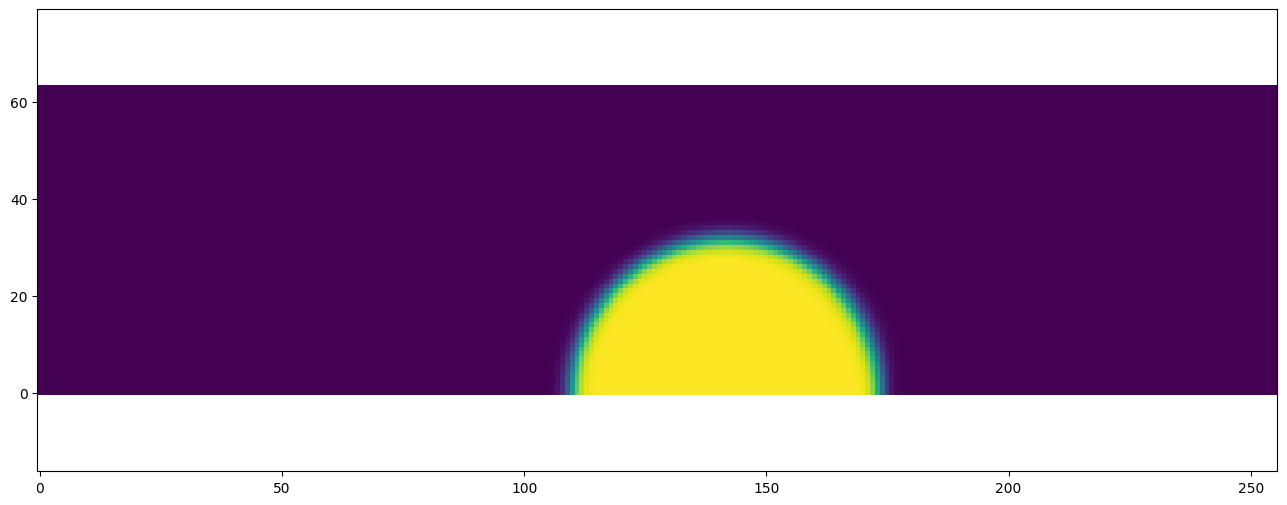

In [23]:
if 'is_test_run' not in globals():
    if gpu:
        dh.all_to_cpu()

    plt.scalar_field(dh.gather_array(C.name))

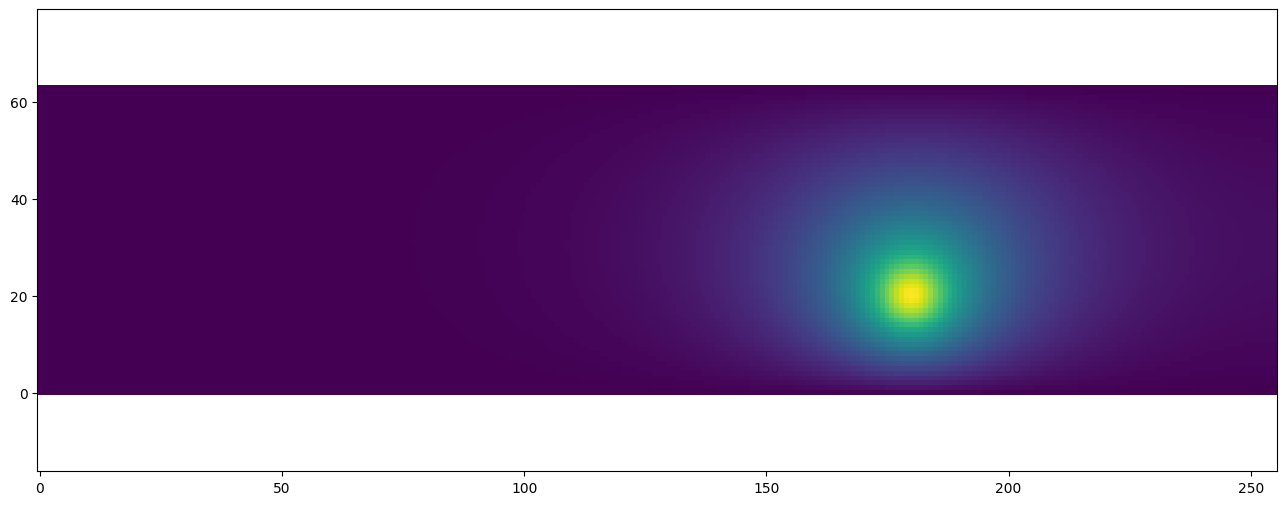

In [24]:
if 'is_test_run' not in globals():
    if gpu:
        dh.all_to_cpu()

    plt.scalar_field(dh.gather_array(temperature.name))

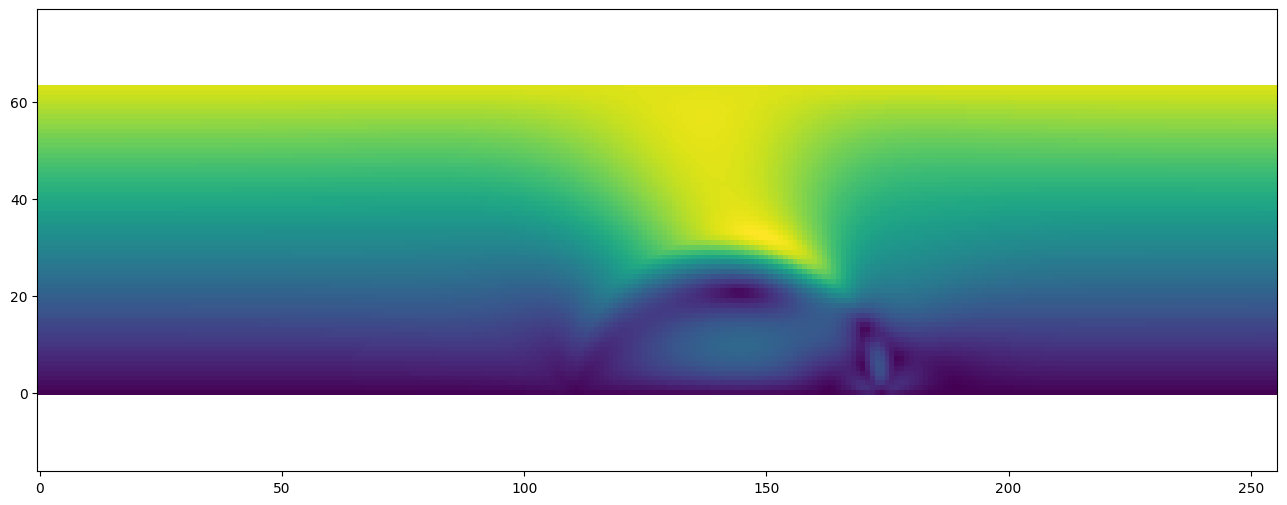

In [25]:
if 'is_test_run' not in globals():
    if gpu:
        dh.all_to_cpu()

    plt.vector_field_magnitude(dh.gather_array(u.name))